# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [31]:
!pip -q install pandas
!pip -q install unidecode
!pip -q install nltk
!pip -q install sklearn
!pip -q install seaborn
!pip -q install yellowbrick

You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --up

In [51]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import seaborn as sns

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:

df_base = pd.read_json('goodreads_books.json')
n_samples = 1000

#df_mini = df_base.sample(n=n_samples, random_state=1)
#df_mini.head()

In [4]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 300
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [5]:
df_mini['genre'].value_counts()

children                  300
comics_graphic            300
fantasy_paranormal        300
history_biography         300
mystery_thriller_crime    300
poetry                    300
romance                   300
young_adult               300
Name: genre, dtype: int64

## Limpeza dos dados

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [8]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [9]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


In [10]:
# df_base.loc[51285, 'description'] # Noisy data

# Lemmazation
Instead of Stemming who reduce inflexions to your base word we could use instead the Lemmazation approuch which groups differented inflexions form of a word

<h2 style="color:#ff3344">Observation</h2>
<span>The code above was converted to a raw cell in order to don't execute until we have a proof that <b>Lemmazation</b> is useful</span>

# Stemming

In [11]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureat, na, nog, eoin, colfer, author, bests...",children,eng
27290,30267927,"[dreamwork, anim, troll, irrever, comedi, extr...",children,eng
8046,16250909,"[yoko, mama, go, trip, japan, yoko, help, mama...",children,eng
28484,17428684,"[minni, friend, get, readi, pamper, pet, minni...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


# TFIDF


### Using the hand made preprocessor

In [12]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aa,aan,aanslag,aantal,aardvark,aaron,abandon,abbadon,abbey,abbeybeast,...,zub,zuckerman,zur,zurael,zusak,zusj,zvezd,zwei,zwerg,zyzzyva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA

In [26]:
N_COMPONENTS = 300
DESIRED_COVARIANCE = 0.95
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [27]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.31


In [28]:
freq_reduced = pca.transform(df_freq)
N_COMPONENTS = freq_reduced.shape[1]
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.125960,0.183417,-0.020403,0.049529,-0.038198,0.028875,-0.031518,0.014246,0.054820,-0.023685,...,0.033807,0.000542,-0.029837,0.033796,-0.044924,-0.020590,0.002146,-0.011767,0.029195,-0.001414
1,0.071276,0.018302,-0.029772,0.043515,0.002491,-0.027318,-0.045365,-0.008495,0.005774,-0.032333,...,-0.018725,-0.002200,0.015298,-0.030145,-0.011730,-0.012751,-0.001722,-0.001702,0.033354,0.033571
2,0.071070,-0.000385,0.015283,0.055172,-0.001572,-0.010208,-0.007987,-0.009004,-0.002027,-0.015852,...,0.018188,-0.011955,0.003563,-0.007797,0.028719,-0.018031,0.004725,-0.018677,0.027734,0.005029
3,0.068137,0.024329,0.019236,0.081935,-0.005309,-0.020839,-0.064337,-0.048397,0.006076,-0.042070,...,-0.001730,-0.007962,0.007354,-0.017961,0.002224,-0.006869,0.005429,-0.013653,-0.013712,-0.009418
4,0.084986,-0.031377,0.011151,0.016333,-0.028918,-0.001568,-0.069103,0.018127,-0.010323,0.032115,...,0.005146,0.013596,-0.023698,-0.024449,-0.020601,0.016485,0.029841,0.032770,-0.005798,-0.007890


In [55]:
scaler = StandardScaler(with_mean=True, with_std=True)
df_freq_reduced[df_freq_reduced.columns] = scaler.fit_transform(df_freq_reduced)
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.030295,2.579003,-0.324499,0.942815,-0.730698,0.635175,-0.671728,0.343884,1.262596,-0.509319,...,1.316456,0.019160,-1.160632,1.340049,-1.766653,-0.801679,0.088625,-0.460555,1.140776,-0.060445
1,-1.228594,0.166399,-0.499451,0.828367,0.108758,-0.575823,-0.978700,-0.171848,0.127323,-0.710301,...,-0.727695,-0.087621,0.599793,-1.156803,-0.467724,-0.494525,-0.063325,-0.065023,1.304518,1.320415
2,-1.233120,-0.106653,0.341842,1.050222,0.024925,-0.207102,-0.150107,-0.183403,-0.053237,-0.327296,...,0.708697,-0.467436,0.142088,-0.284145,1.115107,-0.701438,0.189892,-0.732096,1.083278,0.193892
3,-1.297387,0.254457,0.415659,1.559572,-0.052175,-0.436197,-1.399251,-1.076769,0.134304,-0.936570,...,-0.066367,-0.311958,0.289946,-0.681037,0.078284,-0.264053,0.217543,-0.534684,-0.548383,-0.376347
4,-0.928165,-0.559497,0.264685,0.311046,-0.539244,-0.020901,-1.504913,0.431889,-0.245285,0.787372,...,0.201174,0.527432,-0.921203,-0.934379,-0.814854,0.651000,1.176375,1.289582,-0.236825,-0.316031


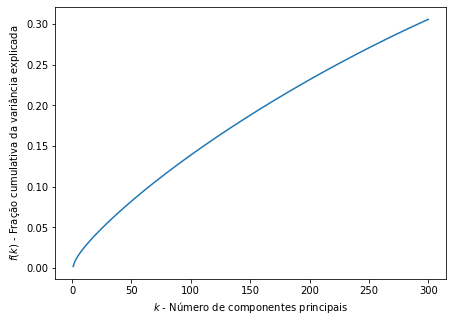

In [29]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, N_COMPONENTS + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$\left[0, \ min(n_{samples} \ , \ n_{features}) \right]$$

# Analise da Quantidade de Grupos

## Elbow Method

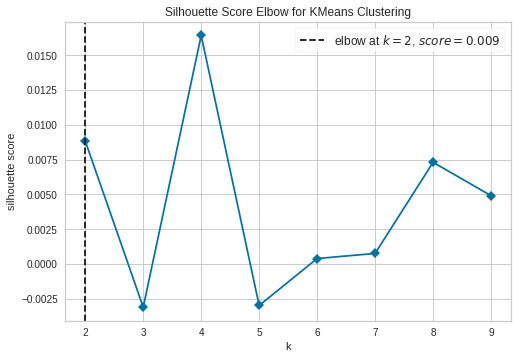

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [56]:
from yellowbrick.cluster import KElbowVisualizer
seed = 1
model = KMeans(init='k-means++', random_state = seed)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(df_freq_reduced.values)
visualizer.show()

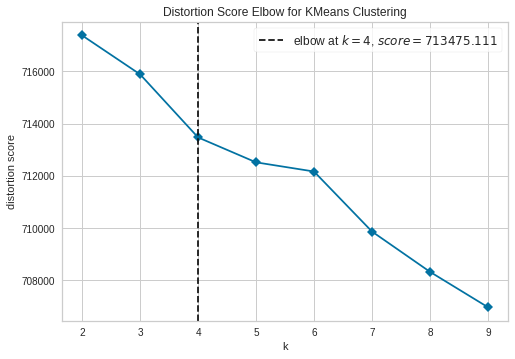

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
from yellowbrick.cluster import KElbowVisualizer
seed = 1
model = KMeans(init='k-means++', random_state = seed)

visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(df_freq_reduced.values)
visualizer.show()


### Silhoutte score

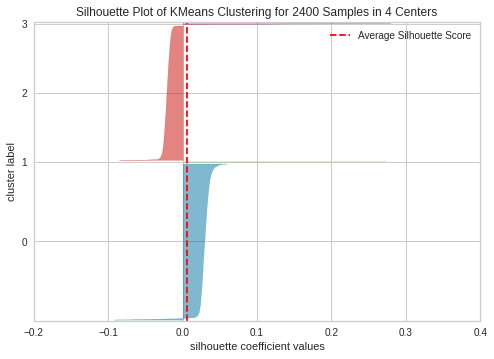

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2400 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [58]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_freq_reduced.values)        # Fit the data to the visualizer
visualizer.show()

### Dendogram

[[0.         0.69033436 0.61968068 ... 0.75373653 0.77256976 0.72516937]
 [0.69033436 0.         0.48415218 ... 0.68279715 0.7086055  0.66640104]
 [0.61968068 0.48415218 0.         ... 0.61302399 0.61269369 0.58457112]
 ...
 [0.75373653 0.68279715 0.61302399 ... 0.         0.72143823 0.72336949]
 [0.77256976 0.7086055  0.61269369 ... 0.72143823 0.         0.69895364]
 [0.72516937 0.66640104 0.58457112 ... 0.72336949 0.69895364 0.        ]]


<AxesSubplot:>

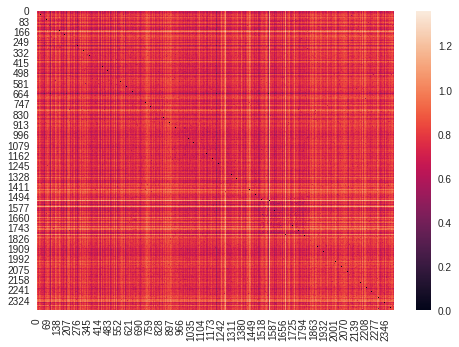

In [50]:
euclidian_dists = metrics.euclidean_distances(df_freq_reduced.values)
print(euclidian_dists)
# euclidian_dists.shape
sns.heatmap(euclidian_dists)
# eucli_dists = hierarchy.linkage(euclidian_dists)
# hierarchy.dendrogram(eucli_dists, color_threshold=1)
# # plt.figure(facecolor='white')
# plt.xticks([], [])
# plt.ylabel('Distância')
# plt.xlabel('Objetos')
# plt.show()

For n_clusters = 2 The average silhouette_score is : 0.008197515110646416
For n_clusters = 3 The average silhouette_score is : 0.0017200085635312064
For n_clusters = 4 The average silhouette_score is : 0.0022948909321220162
For n_clusters = 5 The average silhouette_score is : 0.00013652836497847728
For n_clusters = 6 The average silhouette_score is : 0.006294755191781669
For n_clusters = 7 The average silhouette_score is : -0.012009253511218279
For n_clusters = 8 The average silhouette_score is : 0.0009146601105244902


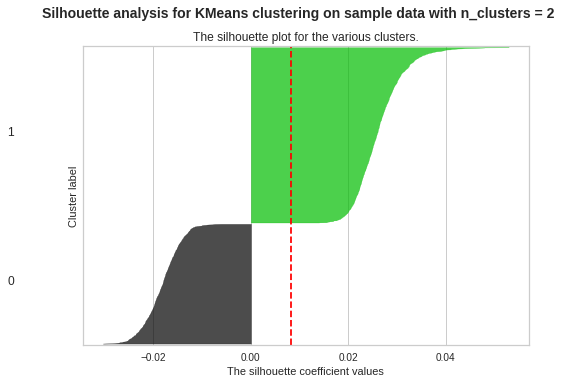

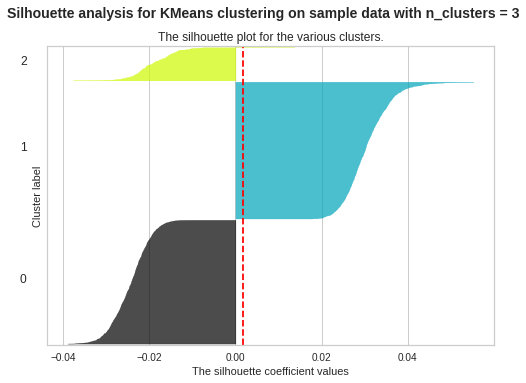

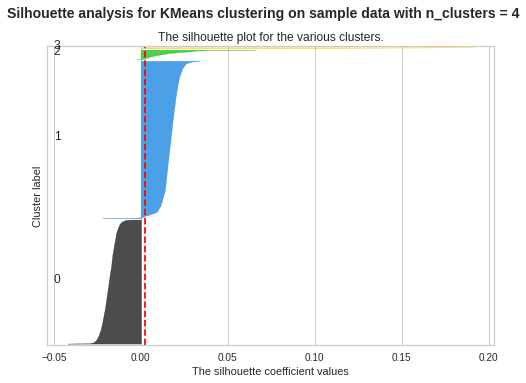

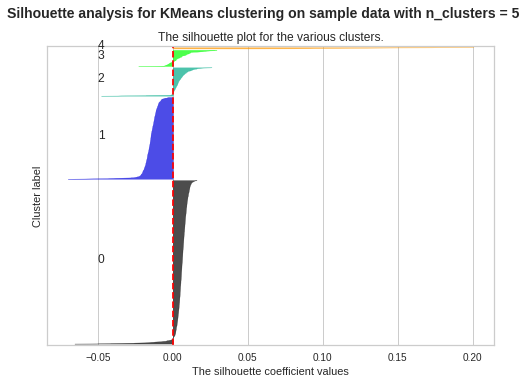

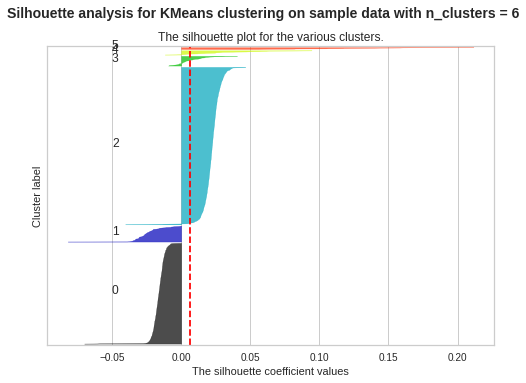

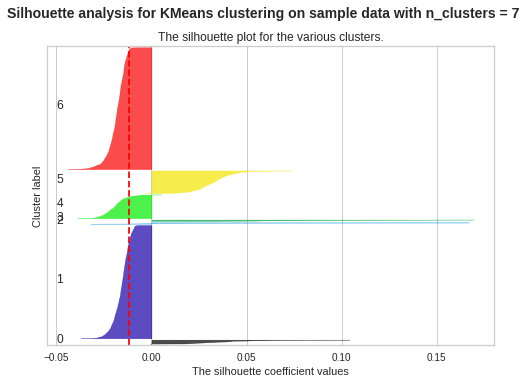

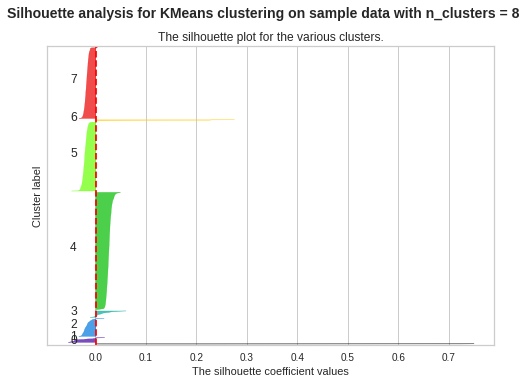

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    #fig.set_size_inches(9, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_freq_reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_freq_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_freq_reduced, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_freq_reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

# K-means

In [24]:
num_labels = df_mini['genre'].unique().size
print(num_labels)

8


In [24]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
y_pred_k_means = model.fit_predict(df_freq_reduced)
# word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)
y_pred_k_means

array([1, 3, 3, ..., 0, 0, 3], dtype=int32)

<AxesSubplot:>

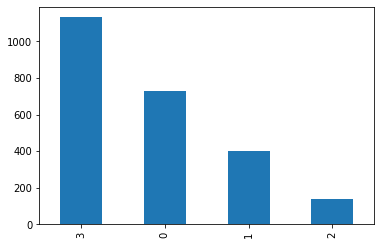

In [25]:
df_mini['pred_k_means'] = y_pred_k_means

df_mini['pred_k_means'].value_counts().plot(kind = 'bar')

# Agrupamento Hierarquico

In [27]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(N_CLUSTERS, linkage = 'ward')
y_pred_ah = model.fit_predict(df_freq_reduced)
y_pred_ah

array([2, 0, 0, ..., 0, 0, 2])

<AxesSubplot:>

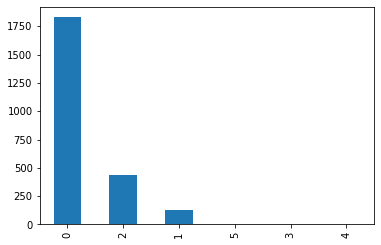

In [28]:
df_mini['y_pred_ah'] = y_pred_ah

df_mini['y_pred_ah'].value_counts().plot(kind = 'bar')

# Agrupamento Espectral

In [29]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = N_CLUSTERS, affinity = 'nearest_neighbors', n_neighbors = 10)
y_pred_sp = model.fit_predict(df_freq_reduced)
y_pred_sp

array([0, 0, 0, ..., 4, 0, 0], dtype=int32)

<AxesSubplot:>

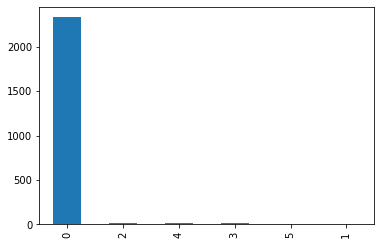

In [30]:
df_mini['y_pred_sp'] = y_pred_sp

df_mini['y_pred_sp'].value_counts().plot(kind = 'bar')

# Evaluate our model

<AxesSubplot:>

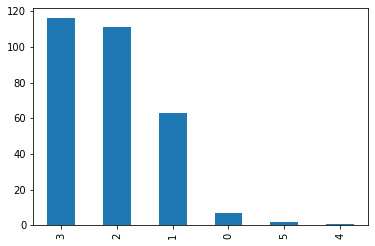

In [31]:
r = df_mini[df_mini.genre == 'children']
r['pred_k_means'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

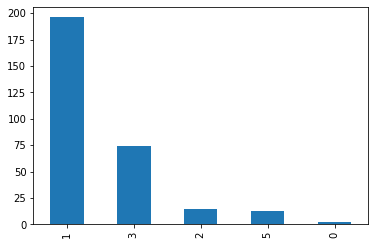

In [32]:
r = df_mini[df_mini.genre == 'romance']
r['pred_k_means'].value_counts().plot(kind = 'bar')

# Cross-validation